In [1]:
pip install pyarrow pandas_ta seaborn matplotlib scikit-learn==1.3.1 yfinance tensorflow.keras


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import pandas_ta as ta
from numpy import NaN
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.linear_model import LogisticRegression
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import os
import yfinance as yf
warnings.filterwarnings("ignore")


2025-04-20 22:09:15.596050: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-20 22:09:28.720343: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-20 22:09:34.200055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745186979.849206    3239 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745186981.356330    3239 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745186995.816435    3239 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import yfinance as yf
warnings.filterwarnings("ignore")



def run_backtest(df, freq='h',name=""):

  
  if df.index.dtype != 'datetime64[ns]':
    raise ValueError("df.index must be in datetime64[ns]")

  
  if 'return_forward' in df.columns:
    df = df.drop(columns=['return_forward'])

  if freq == 'd':
    df = concat_return(df, freq)
    period_in_a_year = 365
  elif freq == 'h':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24
  elif freq == '5min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 12
  elif freq == '15min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 4
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  
  if df['signal'].isnull().values.any():
    raise ValueError("DataFrame contains NA values")
  if 'signal' not in df.columns:
    raise ValueError("DataFrame is missing required column: 'signal'")

  
  
  df['strategy_return'] = df['signal'] * df['return_forward']

  
  num_periods = len(df)
  annual_return_geometric = (1 + df['strategy_return']).prod()**(period_in_a_year/num_periods) - 1
  
  
  annual_return_arithmetic = df['strategy_return'].mean() * period_in_a_year

  
  daily_std = df['strategy_return'].std()
  annual_std = daily_std * np.sqrt(period_in_a_year)
  overall_sharpe = annual_return_arithmetic / annual_std

  print(f"Overall Annual Return: {round(annual_return_geometric*100, 2)}%")
  print("Overall Annual Sharpe Ratio:", round(overall_sharpe, 4))

  
  df['cum_return'] = (1 + df['strategy_return']).cumprod()
  rolling_max = df['cum_return'].cummax()
  df['drawdown'] = (df['cum_return'] - rolling_max) / rolling_max
  max_drawdown = df['drawdown'].min()
  print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

  
  
  
  
  
  
  
  

  
  
  cov_matrix = np.cov(df['strategy_return'], df['return_forward'])
  beta = cov_matrix[0, 1] / cov_matrix[1, 1]

  
  alpha_daily = df['strategy_return'].mean() - beta * df['return_forward'].mean()

  
  alpha_annualized = (1 + alpha_daily) ** period_in_a_year - 1

  print("Alpha:", round(alpha_annualized, 4))
  print("Beta:", round(beta, 4))

  
  df['year'] = df.index.year

  yearly_data = df.groupby('year').apply(lambda subdf: pd.Series({
    'yearly_return': (1 + subdf['strategy_return']).prod()**(period_in_a_year/len(subdf)) - 1,
    'yearly_return_arithmetic': subdf['strategy_return'].mean() * period_in_a_year,
    'yearly_std': subdf['strategy_return'].std() * np.sqrt(period_in_a_year),
    'yearly_beta': np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1] /
                    np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1],
    'yearly_alpha': (
      subdf['strategy_return'].mean()
      - (
        np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1]
        / np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1]
      )
      * subdf['return_forward'].mean()
    ) * period_in_a_year
  })).reset_index()

  yearly_data['yearly_sharpe'] = yearly_data['yearly_return_arithmetic'] / yearly_data['yearly_std']
  yearly_data.drop(columns=['yearly_return_arithmetic'], inplace=True)
  print("\nYearly Metrics:")
  print(yearly_data)

  
  df['cum_return_plot'] = (1 + df['strategy_return']).cumprod() - 1
  df['bh_cum_return_plot'] = (1 + df['return_forward']).cumprod() - 1

  
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['cum_return_plot'], label='Strategy Return')
  plt.plot(df.index, df['bh_cum_return_plot'], label='Buy and Hold')
  plt.title('Strategy Cumulative Return')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.show()

  
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['signal'], label='Signal')
  plt.title('Signal Weight Over Time')
  plt.xlabel('Date')
  plt.ylabel('Weight')
  plt.legend()
  plt.show()


def concat_return(df, freq='h'):
  if freq == 'd':
    file_path = "../../bitcoin_historical_price/btcusd_daily_price.parquet"
  elif freq == 'h':
    file_path = "../../bitcoin_historical_price/btcusd_hourly_price.parquet"
  elif freq == '5min':
    file_path = "../../bitcoin_historical_price/btcusd_5min_price.parquet"
  elif freq == '15min':
    file_path = "../../bitcoin_historical_price/btcusd_15min_price.parquet"
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  if os.path.exists(file_path):
    df_btc_return = pd.read_parquet(file_path)
  else:
    raise FileNotFoundError("Check file path: return data not found.")

  
  merged_df = pd.merge(df, df_btc_return[['return_forward']], left_index=True, right_index=True, how='inner')

  
  merged_df['return_forward'] = merged_df['return_forward'].apply(lambda x: float(x))
  return merged_df

In [4]:
merged_df = pd.read_parquet("../data/full_dataset_feature_engineering_v2.parquet")

In [5]:
df = pd.read_parquet("../data/full_dataset_feature_engineering_v2.parquet")

In [6]:
merged_df.drop(columns=['target'], inplace=True)

In [ ]:
train_start_date = pd.to_datetime("2021-01-01 10:00:00")
train_end_date = pd.to_datetime("2023-12-31 23:00:00")

test_start_date = pd.to_datetime("2024-01-01 00:00:00")
test_end_date = pd.to_datetime("2024-12-31 23:00:00")



price_indicator_train = merged_df.loc[train_start_date:train_end_date]
price_indicator_train_X = price_indicator_train.drop("return_forward",axis=1)
price_indicator_train_Y = price_indicator_train["return_forward"]

price_indicator_test = merged_df.loc[test_start_date:test_end_date]
price_indicator_test_X = price_indicator_test.drop("return_forward",axis=1)
price_indicator_test_Y = price_indicator_test["return_forward"]

price_indicator_test


,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward,sma_5_20_diff,sma_20_50_diff,...,NER_michael saylor_last24,NER_microstrategy_last3,NER_microstrategy_last24,NER_sec_last3,NER_sec_last24,NER_us_last3,reddit_total_sentiment_ewm_5h,reddit_total_sentiment_ewm_24h,reddit_average_sentiment_ewm_5h,reddit_average_sentiment_ewm_24h
2024-01-01 00:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.001385,143.55,210.51,...,1,1,1,0,1,0,0.071577,0.097778,0.003539,0.010173
2024-01-01 01:00:00,1.0,-0.300000,0.000000,0.000000,0.000000,0.200000,0.0,-0.000729,151.35,210.81,...,1,0,1,0,1,0,0.047718,0.089956,0.002359,0.009359
2024-01-01 02:00:00,3.0,-0.233333,0.000000,-0.066667,0.000000,0.333333,0.0,-0.005929,120.60,219.66,...,1,0,1,1,1,0,0.249945,0.135111,0.028840,0.015154
2024-01-01 03:00:00,4.0,0.250000,0.000000,-0.500000,0.000000,-0.175000,0.0,0.000095,43.45,223.39,...,1,0,1,1,1,0,0.166630,0.124302,0.019226,0.013942
2024-01-01 04:00:00,2.0,0.000000,0.000000,-0.450000,0.000000,0.150000,0.0,0.005017,-37.10,221.12,...,1,0,1,1,1,1,0.111087,0.114358,0.012818,0.012827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,7.0,0.342857,0.157143,0.114286,0.014286,0.471429,0.0,-0.006308,339.30,312.86,...,1,1,1,1,1,1,0.369066,0.208662,0.026292,0.015598
2024-12-31 20:00:00,6.0,0.216667,0.016667,0.083333,0.000000,0.483333,0.0,0.002858,-30.20,309.90,...,1,0,1,1,1,1,0.246044,0.191969,0.017528,0.014350
2024-12-31 21:00:00,3.0,0.100000,0.233333,0.200000,0.000000,0.300000,0.0,-0.004142,-238.45,313.73,...,1,0,1,1,1,1,0.164029,0.176611,0.011685,0.013202
2024-12-31 22:00:00,4.0,0.200000,0.200000,0.475000,0.000000,0.925000,0.0,0.000933,-365.30,310.76,...,1,0,1,0,1,1,0.319753,0.212978,0.017354,0.014441


In [8]:
df = pd.read_parquet("../data/full_dataset_feature_engineering_v2.parquet")

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


with open('./pickles/hybrid_feature_scaler.pkl', 'rb') as file:
    feature_scaler = pickle.load(file)

with open('./pickles/hybrid_target_scaler.pkl', 'rb') as file:
    target_scaler = pickle.load(file)

with open('./pickles/hybrid_selected_features.pkl', 'rb') as file:
    selected_features = pickle.load(file)

In [10]:
print(selected_features)

['target', 'atr_7', 'trailing_stop_long_7', '10_band_width', '20_band_width', 'pct_b_10', 'sma_50_200_diff', 'reddit_total_sentiment_ewm_5h', 'rsi_7_acceleration', 'adx', 'sma_20_50_diff', 'tanalysis_absa_ewm_12h', 'sma_50_200_diff_pct_chg', 'reddit_total_sentiment_ewm_24h', 'sma_5_20_diff_pct_chg']


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = df[selected_features].values
y_df = df['return_forward'].values  
original_indexes = df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)


y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))


sequence_length = 12  


X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])


X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)


print(f"X shape: {X_sequences.shape}")  
print(f"y shape: {y_sequences.shape}")  



X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.25062, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (35046, 12, 15)
y shape: (35046, 1)
Total sequences: 35046
Training sequences: 26262
Testing sequences: 8784


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Add
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * 0.1
    else:
        return lr * 0.01

lr_scheduler = LearningRateScheduler(lr_schedule)

def nbeats_block(input_layer, units, block_type='trend', num_layers=4):
    x = input_layer
    for _ in range(num_layers):
        x = Dense(units, activation='relu')(x)

    if block_type == 'trend':
        forecast = Dense(units=1, activation='linear')(x)
    elif block_type == 'seasonal':
        forecast = Dense(units=1, activation='linear')(x)
    
    backcast = Dense(units=input_layer.shape[-1], activation='linear')(x)

    return backcast, forecast

def build_nbeats(input_shape, num_blocks, units, num_layers):
    inputs = Input(shape=input_shape)
    residuals = inputs
    forecasts = []

    for _ in range(num_blocks):
        backcast, forecast = nbeats_block(residuals, units=units, block_type='trend', num_layers=num_layers)
        residuals = Add()([residuals, backcast])
        forecasts.append(forecast)

        backcast, forecast = nbeats_block(residuals, units=units, block_type='seasonal', num_layers=num_layers)
        residuals = Add()([residuals, backcast])
        forecasts.append(forecast)

    output = Add()(forecasts)
    model = Model(inputs, output)
    return model


num_samples = X_train.shape[0]
timesteps = X_train.shape[1]
features = X_train.shape[2]
X_train_reshaped = X_train.reshape(num_samples, timesteps * features)
X_test_reshaped = X_test.reshape(X_test.shape[0], timesteps * features)


input_shape = (X_train_reshaped.shape[1],)
model = build_nbeats(
    input_shape=input_shape,
    num_blocks=3,
    units=128,
    num_layers=4
)


model.compile(optimizer='adam', loss="mse")


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)


history = model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
)


loss = model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {loss}")


predictions = model.predict(X_test_reshaped)


predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
predictions


2025-04-20 22:10:16.496684: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0401 - val_loss: 4.2023e-04 - learning_rate: 0.0010
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0013 - val_loss: 4.7404e-04 - learning_rate: 0.0010
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0012 - val_loss: 3.3784e-04 - learning_rate: 0.0010
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0012 - val_loss: 4.2772e-04 - learning_rate: 0.0010
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0011 - val_loss: 4.1021e-04 - learning_rate: 0.0010
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0011 - val_loss: 3.0654e-04 - learning_rate: 0.0010
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0011 - val_loss: 4.8624e-04 - learning_rate: 0.0010
Epoch 8/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0011 - val_loss: 3.0210e-04 - learning_rate: 0.0010
Epoch 9/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0010 - val_lo

array([[-0.00033777],
       [-0.00013748],
       [ 0.00095375],
       ...,
       [-0.00181963],
       [-0.00109657],
       [-0.00076797]], dtype=float32)

In [ ]:
model.save('nbeats_mse.keras')  


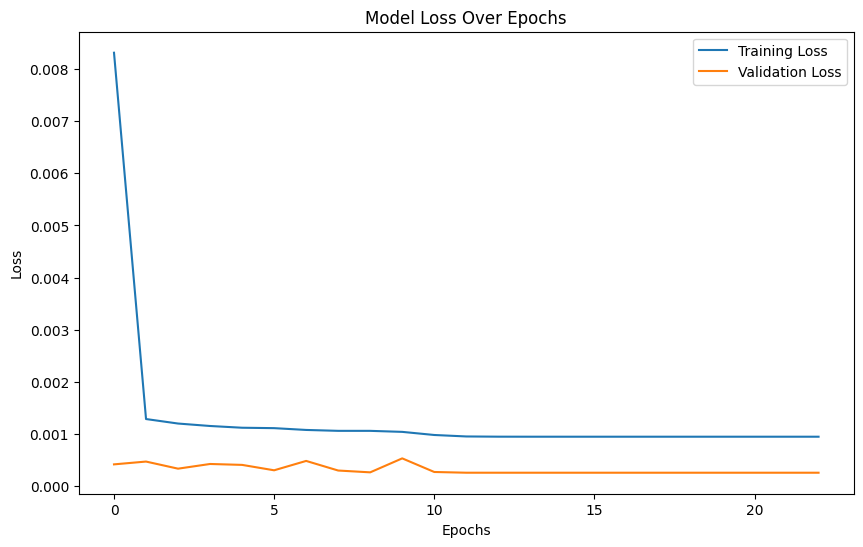

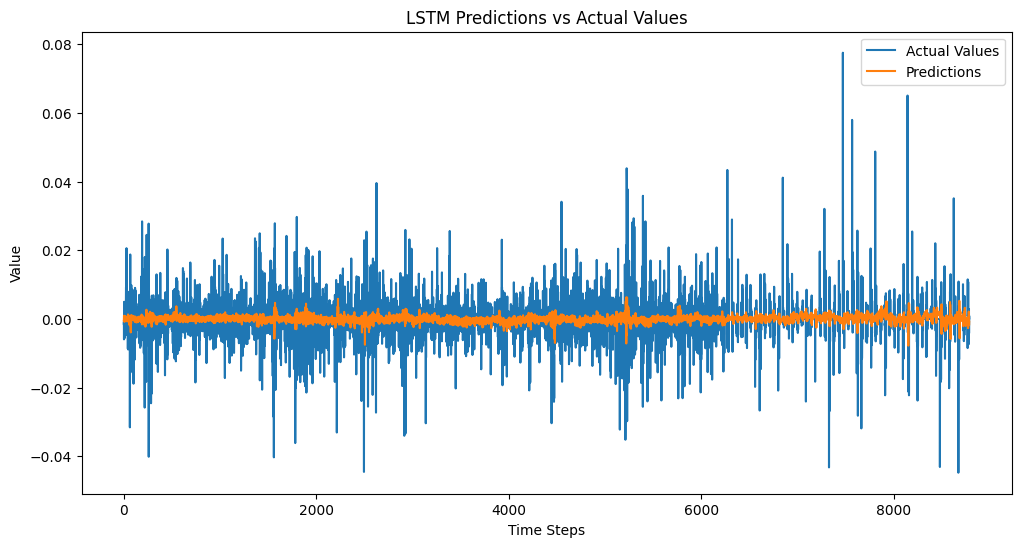

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('nbeats_mse.keras')  
predictions = model.predict(X_test_reshaped)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)





results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)

stat_signal_result_df = results_df
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: 1 if x > 0.0001 else (-1 if x < -0.0001 else 0))
stat_signal_result_df['target'] = df["target"]-1

stat_signal_result_df

275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,Actual,Predicted,signal,target
2024-01-01 00:00:00,-0.001385,-0.000338,-1,-1
2024-01-01 01:00:00,-0.000729,-0.000137,-1,0
2024-01-01 02:00:00,-0.005929,0.000954,1,-1
2024-01-01 03:00:00,0.000095,0.000310,1,0
2024-01-01 04:00:00,0.005017,0.000627,1,1
...,...,...,...,...
2024-12-31 19:00:00,-0.006308,-0.000310,-1,-1
2024-12-31 20:00:00,0.002858,-0.001212,-1,1
2024-12-31 21:00:00,-0.004142,-0.001820,-1,-1
2024-12-31 22:00:00,0.000933,-0.001097,-1,0


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_true = stat_signal_result_df['target']
y_pred = stat_signal_result_df['signal']



accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")


print("\\nMetrics per class:")
precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
labels = sorted(y_true.unique()) 

for i, label in enumerate(labels):
    print(f"  Class {label}:")
    print(f"    Precision: {precision_per_class[i]:.4f}")
    print(f"    Recall:    {recall_per_class[i]:.4f}")
    print(f"    F1 Score:  {f1_per_class[i]:.4f}")


Accuracy: 0.3365
Precision (Weighted): 0.3493
Recall (Weighted): 0.3365
F1 Score (Weighted): 0.3089
\nMetrics per class:
  Class -1:
    Precision: 0.3464
    Recall:    0.4853
    F1 Score:  0.4042
  Class 0:
    Precision: 0.3797
    Recall:    0.1142
    F1 Score:  0.1756
  Class 1:
    Precision: 0.3172
    Recall:    0.4532
    F1 Score:  0.3732


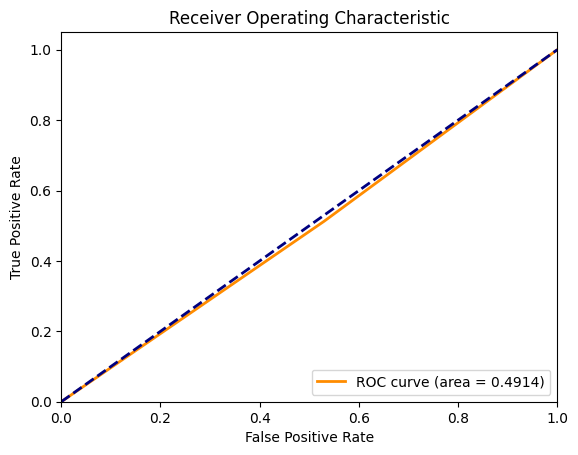

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score



mask = y_pred != 0
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]



y_true_binary = np.where(y_true_filtered == 1, 1, 0)


fpr, tpr, _ = roc_curve(y_true_binary, y_pred_filtered)


roc_auc = roc_auc_score(y_true_binary, y_pred_filtered)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Overall Annual Return: 39.68%
Overall Annual Sharpe Ratio: 0.9181
Maximum Drawdown: -37.34 %
Alpha: 0.4749
Beta: 0.0761

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024        0.39683    0.500444     0.076137      0.388565       0.918065


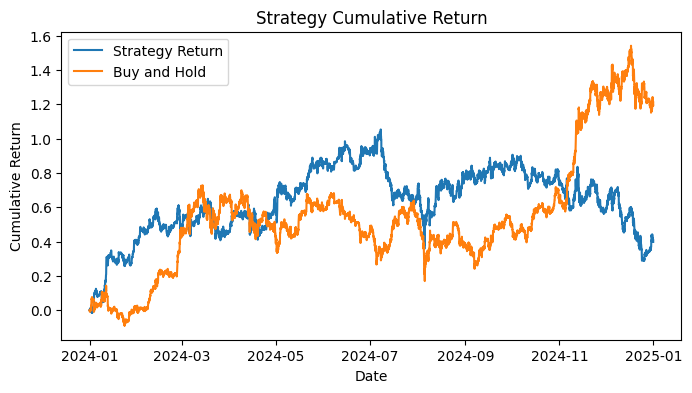

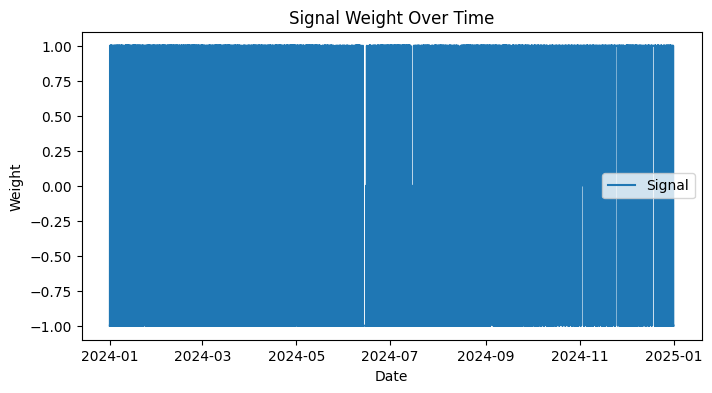

In [18]:
run_backtest(stat_signal_result_df, name ="NBeats_MSE_Hybrid")

In [19]:
df = pd.read_parquet("../data/full_dataset_feature_engineering_v2.parquet")

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


with open('./pickles/hybrid_feature_scaler.pkl', 'rb') as file:
    feature_scaler = pickle.load(file)

with open('./pickles/hybrid_target_scaler.pkl', 'rb') as file:
    target_scaler = pickle.load(file)

with open('./pickles/hybrid_selected_features.pkl', 'rb') as file:
    selected_features = pickle.load(file)

In [21]:
print(selected_features)

['target', 'atr_7', 'trailing_stop_long_7', '10_band_width', '20_band_width', 'pct_b_10', 'sma_50_200_diff', 'reddit_total_sentiment_ewm_5h', 'rsi_7_acceleration', 'adx', 'sma_20_50_diff', 'tanalysis_absa_ewm_12h', 'sma_50_200_diff_pct_chg', 'reddit_total_sentiment_ewm_24h', 'sma_5_20_diff_pct_chg']


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = df[selected_features].values
y_df = df['return_forward'].values  
original_indexes = df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)


y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))


sequence_length = 12  


X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])


X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)


print(f"X shape: {X_sequences.shape}")  
print(f"y shape: {y_sequences.shape}")  



X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.25062, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (35046, 12, 15)
y shape: (35046, 1)
Total sequences: 35046
Training sequences: 26262
Testing sequences: 8784


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Add
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * 0.1
    else:
        return lr * 0.01

lr_scheduler = LearningRateScheduler(lr_schedule)

def nbeats_block(input_layer, units, block_type='trend', num_layers=4):
    x = input_layer
    for _ in range(num_layers):
        x = Dense(units, activation='relu')(x)

    if block_type == 'trend':
        forecast = Dense(units=1, activation='linear')(x)
    elif block_type == 'seasonal':
        forecast = Dense(units=1, activation='linear')(x)
    
    backcast = Dense(units=input_layer.shape[-1], activation='linear')(x)

    return backcast, forecast

def build_nbeats(input_shape, num_blocks, units, num_layers):
    inputs = Input(shape=input_shape)
    residuals = inputs
    forecasts = []

    for _ in range(num_blocks):
        backcast, forecast = nbeats_block(residuals, units=units, block_type='trend', num_layers=num_layers)
        residuals = Add()([residuals, backcast])
        forecasts.append(forecast)

        backcast, forecast = nbeats_block(residuals, units=units, block_type='seasonal', num_layers=num_layers)
        residuals = Add()([residuals, backcast])
        forecasts.append(forecast)

    output = Add()(forecasts)
    model = Model(inputs, output)
    return model


num_samples = X_train.shape[0]
timesteps = X_train.shape[1]
features = X_train.shape[2]
X_train_reshaped = X_train.reshape(num_samples, timesteps * features)
X_test_reshaped = X_test.reshape(X_test.shape[0], timesteps * features)


input_shape = (X_train_reshaped.shape[1],)
model = build_nbeats(
    input_shape=input_shape,
    num_blocks=3,
    units=128,
    num_layers=4
)


model.compile(optimizer='adam', loss="mse")


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)


history = model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
)


loss = model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {loss}")


predictions = model.predict(X_test_reshaped)


predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
predictions


Epoch 1/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0537 - val_loss: 5.2601e-04 - learning_rate: 0.0010
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0013 - val_loss: 8.9552e-04 - learning_rate: 0.0010
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0013 - val_loss: 3.6262e-04 - learning_rate: 0.0010
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0011 - val_loss: 3.4859e-04 - learning_rate: 0.0010
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0011 - val_loss: 2.8783e-04 - learning_rate: 0.0010
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0010 - val_loss: 3.7481e-04 - learning_rate: 0.0010
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0010 - val_loss: 2.7420e-04 - learning_rate: 0.0010
Epoch 8/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0010 - val_loss: 4.6518e-04 - learning_rate: 0.0010
Epoch 9/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0011 - val_loss:

array([[ 0.00063501],
       [-0.00025827],
       [ 0.00054298],
       ...,
       [-0.00293775],
       [-0.0017303 ],
       [-0.00194904]], dtype=float32)

In [ ]:
model.save('nbeats_dl.keras')  


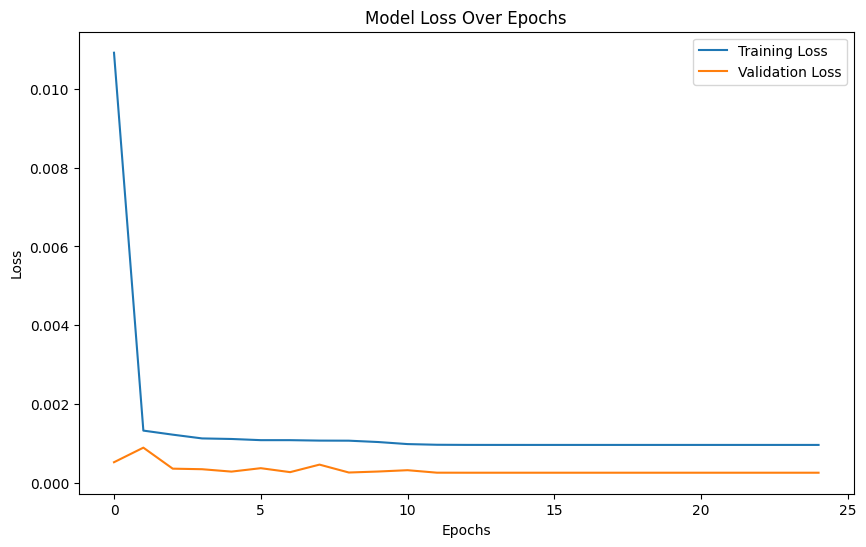

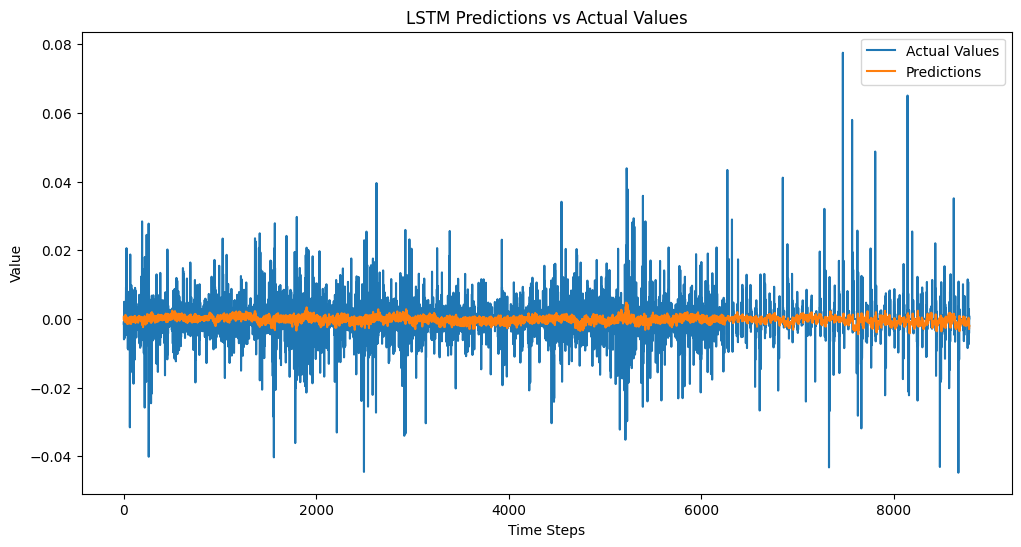

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('nbeats_dl.keras')  
predictions = model.predict(X_test_reshaped)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)





results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)

stat_signal_result_df = results_df
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: 1 if x > 0.0001 else (-1 if x < -0.0001 else 0))
stat_signal_result_df['target'] = df["target"]-1

stat_signal_result_df

275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,Actual,Predicted,signal,target
2024-01-01 00:00:00,-0.001385,0.000635,1,-1
2024-01-01 01:00:00,-0.000729,-0.000258,-1,0
2024-01-01 02:00:00,-0.005929,0.000543,1,-1
2024-01-01 03:00:00,0.000095,-0.000274,-1,0
2024-01-01 04:00:00,0.005017,-0.000357,-1,1
...,...,...,...,...
2024-12-31 19:00:00,-0.006308,-0.001694,-1,-1
2024-12-31 20:00:00,0.002858,-0.001567,-1,1
2024-12-31 21:00:00,-0.004142,-0.002938,-1,-1
2024-12-31 22:00:00,0.000933,-0.001730,-1,0


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_true = stat_signal_result_df['target']
y_pred = stat_signal_result_df['signal']



accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")


print("\\nMetrics per class:")
precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
labels = sorted(y_true.unique()) 

for i, label in enumerate(labels):
    print(f"  Class {label}:")
    print(f"    Precision: {precision_per_class[i]:.4f}")
    print(f"    Recall:    {recall_per_class[i]:.4f}")
    print(f"    F1 Score:  {f1_per_class[i]:.4f}")


Accuracy: 0.3177
Precision (Weighted): 0.3261
Recall (Weighted): 0.3177
F1 Score (Weighted): 0.2868
\nMetrics per class:
  Class -1:
    Precision: 0.2860
    Recall:    0.4607
    F1 Score:  0.3530
  Class 0:
    Precision: 0.3376
    Recall:    0.0889
    F1 Score:  0.1407
  Class 1:
    Precision: 0.3500
    Recall:    0.4472
    F1 Score:  0.3927


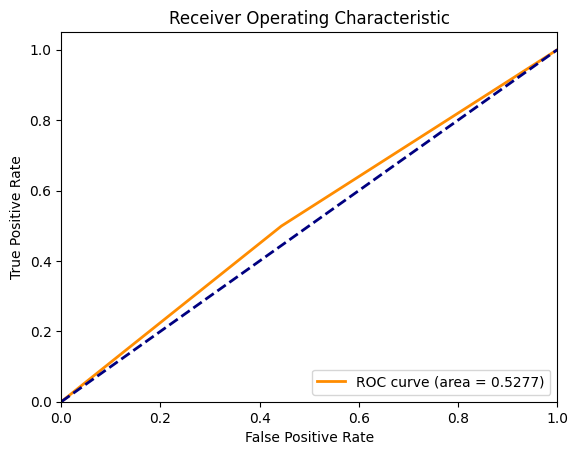

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score



mask = y_pred != 0
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]



y_true_binary = np.where(y_true_filtered == 1, 1, 0)


fpr, tpr, _ = roc_curve(y_true_binary, y_pred_filtered)


roc_auc = roc_auc_score(y_true_binary, y_pred_filtered)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Overall Annual Return: -18.22%
Overall Annual Sharpe Ratio: -0.1488
Maximum Drawdown: -49.65 %
Alpha: -0.0574
Beta: -0.0168

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024      -0.182227    0.502766    -0.016794     -0.059153       -0.14875


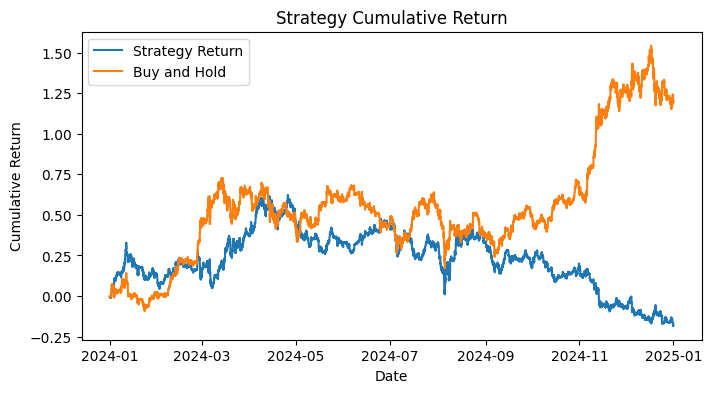

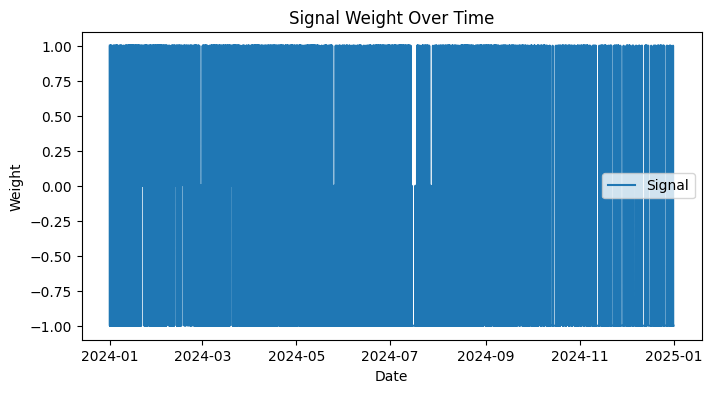

In [29]:
run_backtest(stat_signal_result_df, name ="NBeats_Directional_Hybrid")

In [30]:
df = pd.read_parquet("../data/full_dataset_feature_engineering_v2.parquet")

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


with open('./pickles/hybrid_feature_scaler.pkl', 'rb') as file:
    feature_scaler = pickle.load(file)

with open('./pickles/hybrid_target_scaler.pkl', 'rb') as file:
    target_scaler = pickle.load(file)

with open('./pickles/hybrid_selected_features.pkl', 'rb') as file:
    selected_features = pickle.load(file)

In [32]:
print(selected_features)

['target', 'atr_7', 'trailing_stop_long_7', '10_band_width', '20_band_width', 'pct_b_10', 'sma_50_200_diff', 'reddit_total_sentiment_ewm_5h', 'rsi_7_acceleration', 'adx', 'sma_20_50_diff', 'tanalysis_absa_ewm_12h', 'sma_50_200_diff_pct_chg', 'reddit_total_sentiment_ewm_24h', 'sma_5_20_diff_pct_chg']


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = df[selected_features].values
y_df = df['return_forward'].values  
original_indexes = df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)


y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))


sequence_length = 12  


X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])


X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)


print(f"X shape: {X_sequences.shape}")  
print(f"y shape: {y_sequences.shape}")  



X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.25062, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (35046, 12, 15)
y shape: (35046, 1)
Total sequences: 35046
Training sequences: 26262
Testing sequences: 8784


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Add
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import backend as K
from keras.saving import register_keras_serializable

def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * 0.1
    else:
        return lr * 0.01

lr_scheduler = LearningRateScheduler(lr_schedule)

@register_keras_serializable(package="Custom", name="weighted_loss")
def weighted_loss(y_true, y_pred):
    
    returns = y_pred - y_true
    
    
    positive_weight = 0.5
    negative_weight = 1.5
    
    
    loss = K.mean(K.switch(returns > 0, positive_weight * K.square(returns), negative_weight * K.square(returns)))
    
    return loss


def nbeats_block(input_layer, units, block_type='trend', num_layers=4):
    x = input_layer
    for _ in range(num_layers):
        x = Dense(units, activation='relu')(x)

    if block_type == 'trend':
        forecast = Dense(units=1, activation='linear')(x)
    elif block_type == 'seasonal':
        forecast = Dense(units=1, activation='linear')(x)
    
    backcast = Dense(units=input_layer.shape[-1], activation='linear')(x)

    return backcast, forecast

def build_nbeats(input_shape, num_blocks, units, num_layers):
    inputs = Input(shape=input_shape)
    residuals = inputs
    forecasts = []

    for _ in range(num_blocks):
        backcast, forecast = nbeats_block(residuals, units=units, block_type='trend', num_layers=num_layers)
        residuals = Add()([residuals, backcast])
        forecasts.append(forecast)

        backcast, forecast = nbeats_block(residuals, units=units, block_type='seasonal', num_layers=num_layers)
        residuals = Add()([residuals, backcast])
        forecasts.append(forecast)

    output = Add()(forecasts)
    model = Model(inputs, output)
    return model


num_samples = X_train.shape[0]
timesteps = X_train.shape[1]
features = X_train.shape[2]
X_train_reshaped = X_train.reshape(num_samples, timesteps * features)
X_test_reshaped = X_test.reshape(X_test.shape[0], timesteps * features)


input_shape = (X_train_reshaped.shape[1],)
model = build_nbeats(
    input_shape=input_shape,
    num_blocks=3,
    units=128,
    num_layers=4
)


model.compile(optimizer='adam', loss=weighted_loss)


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)


history = model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
)


loss = model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {loss}")


predictions = model.predict(X_test_reshaped)


predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
predictions


Epoch 1/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0396 - val_loss: 4.0042e-04 - learning_rate: 0.0010
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0011 - val_loss: 3.5009e-04 - learning_rate: 0.0010
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0010 - val_loss: 3.1735e-04 - learning_rate: 0.0010
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 9.8046e-04 - val_loss: 7.1891e-04 - learning_rate: 0.0010
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0010 - val_loss: 2.7559e-04 - learning_rate: 0.0010
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 9.4592e-04 - val_loss: 4.2850e-04 - learning_rate: 0.0010
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 8.9289e-04 - val_loss: 3.9659e-04 - learning_rate: 0.0010
Epoch 8/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 9.0719e-04 - val_loss: 3.9756e-04 - learning_rate: 0.0010
Epoch 9/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 9.

array([[ 0.00149072],
       [ 0.00117553],
       [ 0.00202257],
       ...,
       [ 0.00064902],
       [ 0.00078185],
       [-0.00031306]], dtype=float32)

In [ ]:
model.save('nbeats_wl.keras')  


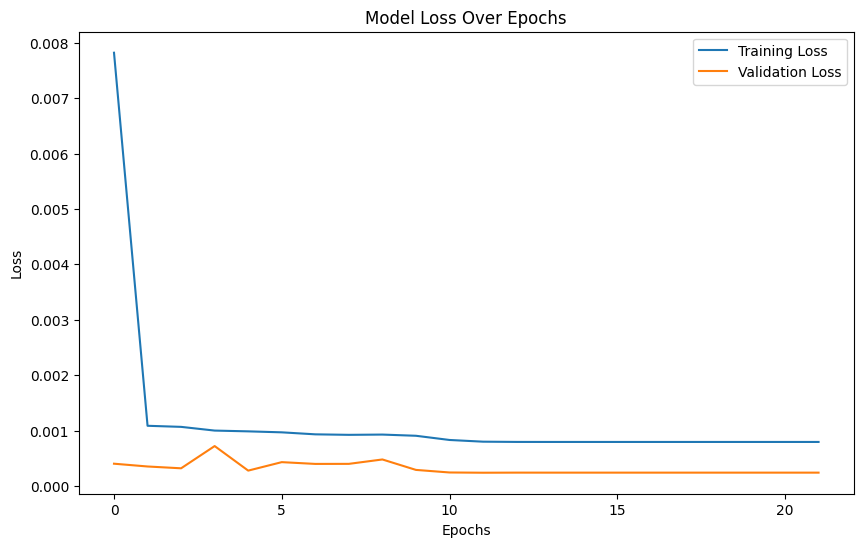

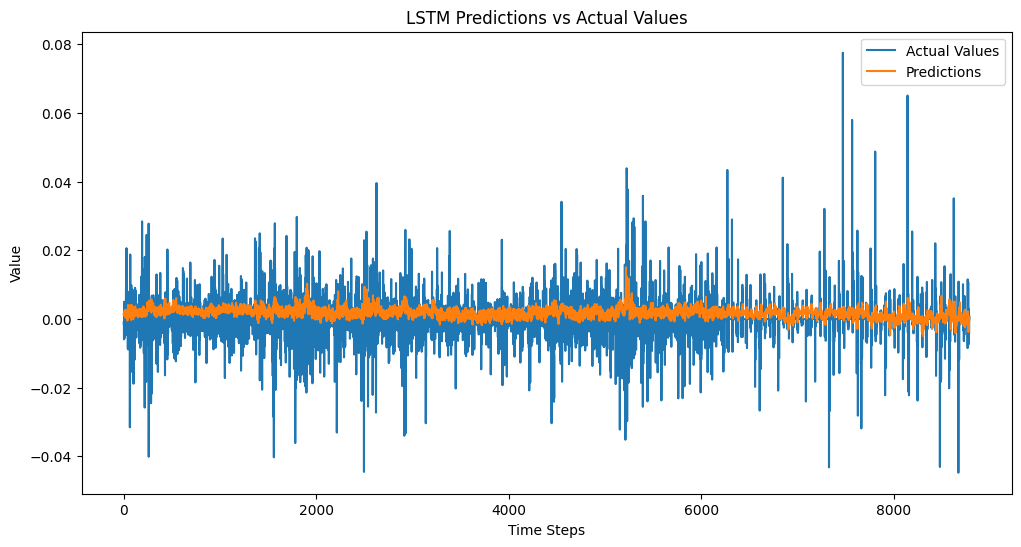

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('nbeats_wl.keras')  
predictions = model.predict(X_test_reshaped)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)





results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)

stat_signal_result_df = results_df
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: 1 if x > 0.0001 else (-1 if x < -0.0001 else 0))
stat_signal_result_df['target'] = df["target"]-1

stat_signal_result_df

275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,Actual,Predicted,signal,target
2024-01-01 00:00:00,-0.001385,0.001491,1,-1
2024-01-01 01:00:00,-0.000729,0.001176,1,0
2024-01-01 02:00:00,-0.005929,0.002023,1,-1
2024-01-01 03:00:00,0.000095,0.001869,1,0
2024-01-01 04:00:00,0.005017,0.001353,1,1
...,...,...,...,...
2024-12-31 19:00:00,-0.006308,0.000535,1,-1
2024-12-31 20:00:00,0.002858,0.000436,1,1
2024-12-31 21:00:00,-0.004142,0.000649,1,-1
2024-12-31 22:00:00,0.000933,0.000782,1,0


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_true = stat_signal_result_df['target']
y_pred = stat_signal_result_df['signal']



accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")


print("\\nMetrics per class:")
precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
labels = sorted(y_true.unique()) 

for i, label in enumerate(labels):
    print(f"  Class {label}:")
    print(f"    Precision: {precision_per_class[i]:.4f}")
    print(f"    Recall:    {recall_per_class[i]:.4f}")
    print(f"    F1 Score:  {f1_per_class[i]:.4f}")


Accuracy: 0.3311
Precision (Weighted): 0.3687
Recall (Weighted): 0.3311
F1 Score (Weighted): 0.2060
\nMetrics per class:
  Class -1:
    Precision: 0.2007
    Recall:    0.0434
    F1 Score:  0.0714
  Class 0:
    Precision: 0.5340
    Recall:    0.0336
    F1 Score:  0.0632
  Class 1:
    Precision: 0.3352
    Recall:    0.9375
    F1 Score:  0.4938


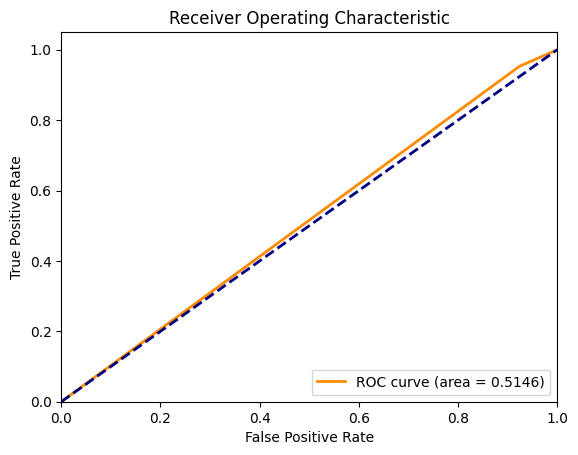

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score



mask = y_pred != 0
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]



y_true_binary = np.where(y_true_filtered == 1, 1, 0)


fpr, tpr, _ = roc_curve(y_true_binary, y_pred_filtered)


roc_auc = roc_auc_score(y_true_binary, y_pred_filtered)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Overall Annual Return: 20.81%
Overall Annual Sharpe Ratio: 0.6231
Maximum Drawdown: -35.31 %
Alpha: -0.3685
Beta: 0.8438

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.208113    0.523013     0.843805     -0.459583       0.623129


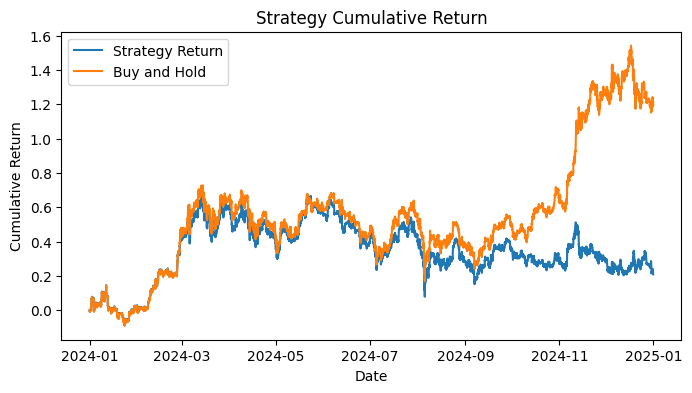

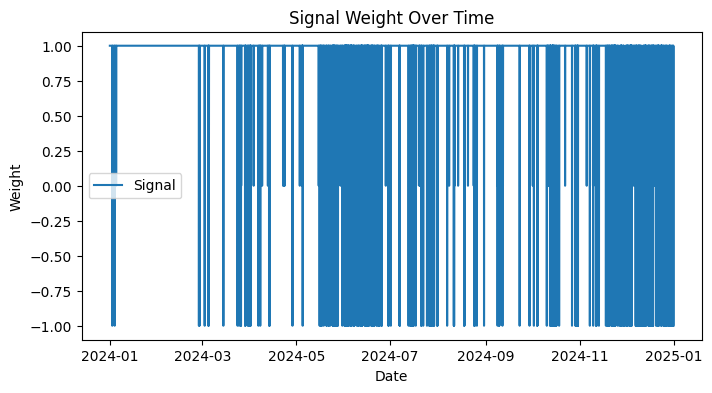

In [41]:
run_backtest(stat_signal_result_df, name ="NBeats_WL_Hybrid")